In [32]:
import pandas as pd
import numpy as np
import json
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# get binomial indices and names
with open('../Data/Processed/label_dict.txt', 'r') as f:
    indexed_labels = json.load(f)
indices = sorted(indexed_labels.keys())

# read the data
data = pd.read_csv("../Data/Main/RSA_results.txt", comment='#', header=None, 
                   names=['Time', 'IPHash', 'Controller', 'Item', 'Element', 'Type', 'Group', 'Field', 'Value']) 

# preprocessing
def item2condition(number):
    """retrieve binomial condition from item number
    according to the experimental design on Ibex Farm"""
    condNum = (number - 4) % 5
    if condNum % 3 == 0:
        return "AB"
    elif condNum % 3 == 1:
        return "BA"
    else:
        return "XX"
    
del data['Controller']
del data['Element']
data['Item'] = data['Item'].apply(item2condition)
data = data[data['Field']!='_REACTION_TIME_']
data.head()

,Time,IPHash,Item,Type,Group,Field,Value
1,1513003540,4d746d235e3651899a1f17adc36c8142,XX,image,24.0,2+60+120+0_1+120+60+1_2+120+60+2,1+120+60+1
3,1513003540,4d746d235e3651899a1f17adc36c8142,BA,image,21.0,1+120+120+0_1+120+60+1_2+120+60+2,1+120+120+0
5,1513003540,4d746d235e3651899a1f17adc36c8142,BA,image,18.0,2+120+60+0_2+60+120+1_1+120+120+2,1+120+120+2
7,1513003540,4d746d235e3651899a1f17adc36c8142,BA,image,36.0,2+60+120+0_1+120+60+1_1+120+120+2,1+120+120+2
9,1513003540,4d746d235e3651899a1f17adc36c8142,XX,image,4.0,2+120+120+0_1+60+120+1_1+120+60+2,1+60+120+1


In [8]:
# check the number of participants
len(data['Time'].unique())

106

In [9]:
# check language
lang_responses = data['Value'][data['Field'] == 'language'].tolist() 
any([l != 'native' for l in lang_responses])
# TODO: exclude non-native speakers if present

False

In [10]:
# get purpose
#data['Value'][data['Field'] == 'purpose'].tolist()

In [11]:
# get comments
#data['Value'][data['Field'] == 'comments'].tolist() 

In [27]:
def get_vis_condition(label):
    """decode the visual condition from the label.
    order: image order (1 - AB, 2 - BA)
    size1, size2: size of images A and B
    location: position of image pair on the screen (0 - top, 1 - center, 2 - bottom)"""
    condlist = label.split("+")
    return {'order': int(condlist[0]),
           'size1': int(condlist[1]),
           'size2': int(condlist[2]),
           'location': int(condlist[3])}

def get_all_vis_conditions(long_label):
    labels = long_label.split("_")
    label_list = []
    for i in range(3):
        label_list.append(get_vis_condition(labels[i]))
    return label_list

def get_binomial(group_num, indices, indexed_labels):
    return indexed_labels[indices[group_num-1]]

# Save the Data (for the modeling section)

In [31]:
# get results (exclude prior elicitation condition)
raw_values = data['Value'][(data['Item']!='XX') & (data['Type'] == 'image')]
raw_lists = data['Field'][(data['Item']!='XX') & (data['Type'] == 'image')]
order = data['Item'][(data['Item']!='XX') & (data['Type'] == 'image')]
values = raw_values.apply(get_vis_condition)
lists = raw_lists.apply(get_all_vis_conditions)

In [16]:
len(values)

3052

In [20]:
with open('../Data/Processed/lists.txt', 'w') as f1:
    json.dump(lists.tolist(), f1)
with open('../Data/Processed/values.txt', 'w') as f2:
    json.dump(values.tolist(), f2)
with open('../Data/Processed/order.txt', 'w') as f3:
    json.dump(order.tolist(), f3)

In [ ]:
# unused
groups = data['Group'][(data['Item']!='XX') & (data['Type'] == 'image')]
groups = groups - 1
with open('../Data/Processed/groups.txt', 'w') as f4:
    json.dump(groups.tolist(), f4)

# Prior preferences

In [50]:
def compare_size(size1, size2, order):
    """Returns -1 is the image on the left is larger,
    1 if the image on the right is larger, and 0 if they are the same size"""
    if order==1:
        left_size = size1
        right_size = size2
    else:
        left_size = size2
        right_size = size1
        
    if left_size > right_size:
        return -1
    elif left_size < right_size:
        return 1
    else:
        return 0

In [ ]:
# get size and position preferences for the prior elicitation condition ('XX')

prior_data = data[(data['Item']=='XX') & (data['Type'] == 'image')]
prior_data['Value'] = prior_data['Value'].apply(get_vis_condition)
prior_data['Field'] = prior_data['Field'].apply(get_all_vis_conditions)

top_prior = []
center_prior = []
bottom_prior = []

for subID in data['Time'].unique():
    data_sub = prior_data[prior_data['Time']==subID]
    location = [r['location'] for r in data_sub['Value']]
    total = len(data_sub)
    top_prior.append(location.count(0) * 1.0 / total)
    center_prior.append(location.count(1) * 1.0 / total)
    bottom_prior.append(location.count(2) * 1.0 / total)

position_vals = [np.mean(top_prior), np.mean(center_prior), np.mean(bottom_prior)]
position_std = [np.std(top_prior), np.std(center_prior), np.std(bottom_prior)]

left_smaller = []
equal = []
left_larger = []

size_prior = [0,0,0]
for subID in data['Time'].unique():
    data_sub = prior_data[prior_data['Time']==subID]
    sizes = [compare_size(r['size1'], r['size2'], r['order']) for r in data_sub['Value']]
    total = len(data_sub)
    left_smaller.append(sizes.count(-1) * 1.0 / total)
    equal.append(sizes.count(0) * 1.0 / total)
    left_larger.append(sizes.count(1) * 1.0 / total)

size_vals = [np.mean(left_smaller), np.mean(equal), np.mean(left_larger)]
size_std = [np.std(left_smaller), np.std(equal), np.std(left_larger)]

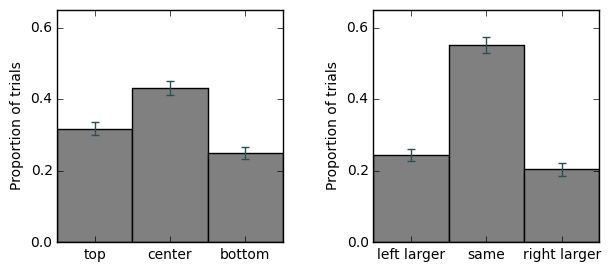

In [40]:
# plot the result 

num_subs = len(data['Time'].unique())

fig = plt.figure(figsize=(7,3))
ax = plt.subplot(121)

position_stderr = [s / math.sqrt(num_subs) for s in position_std]
size_stderr = [s / math.sqrt(num_subs) for s in size_std]

plt.bar(range(3), position_vals, color='gray', width=1, yerr=position_stderr, 
        error_kw=dict(ecolor='darkslategray', lw=1, capsize=3, capthick=1))

plt.xticks([x + 0.5 for x in range(3)], ['top', 'center', 'bottom'], fontsize=10)
plt.ylabel('Proportion of trials', fontsize=10)
plt.ylim([0, 0.65])
ax.set_yticks(ax.get_yticks()[::2])

ax = plt.subplot(122)
#plt.hist(sizes, bins=[-1.5,-0.5,0.5,1.5], color='gray')
plt.bar(range(3), size_vals, color='gray', width=1, yerr=size_stderr, 
        error_kw=dict(ecolor='darkslategray', lw=1, capsize=3, capthick=1))
ax.set_yticks(ax.get_yticks()[::2])

plt.xticks([x + 0.5 for x in range(3)], ['left larger', 'same', 'right larger'], fontsize=10)
plt.ylabel('Proportion of trials', fontsize=10)
plt.ylim([0, 0.65])

fig.subplots_adjust(wspace=.4)

# Comparing behavioral data with predictions

In [45]:
# get behavior info 

def split_data(data):
    raw_results_BA = data[(data['Item']=='BA') & (data['Type'] == 'image')]
    results_BA = raw_results_BA['Value'].apply(get_vis_condition)
    raw_results_AB = data[(data['Item']=='AB') & (data['Type'] == 'image')]
    results_AB = raw_results_AB['Value'].apply(get_vis_condition)
    return [results_AB, results_BA]

def get_pct_left(results_AB, results_BA):
    total = len(results_BA) + len(results_AB)
    order_AB = [r['order'] for r in results_AB]
    order_BA = [r['order'] for r in results_BA]
    pctLeft = 1.0 * (order_AB.count(1) + order_BA.count(2)) / total
    return pctLeft

# get behavior info - size
def get_size_stats(results_AB, results_BA):
    total = len(results_BA) + len(results_AB)
    numSmallerAB = sum([x['size1'] < x['size2'] for x in results_AB])
    numSmallerBA = sum([x['size2'] < x['size1'] for x in results_BA])
    numSameAB = sum([x['size1'] == x['size2'] for x in results_AB])
    numSameBA = sum([x['size1'] == x['size2'] for x in results_BA])
    pctSmaller = 1.0 * (numSmallerAB + numSmallerBA) / total
    pctSame = 1.0 * (numSameAB + numSameBA) / total
    return [pctSmaller, pctSame]

def disp_stats(nums):
    print('Mean: ' + str(np.mean(nums)))
    print('STD: ' + str(np.std(nums)) + '\n')

def get_stats_all_subs(data):
    pct_left = []
    pct_smaller = []
    pct_same = []
    for subID in data['Time'].unique():
        data_sub = data[data['Time']==subID]
        [results_AB, results_BA] = split_data(data_sub)
        pct_left.append(get_pct_left(results_AB, results_BA))
        size_res = get_size_stats(results_AB, results_BA)
        pct_smaller.append(size_res[0])
        pct_same.append(size_res[1])
    pct_right = [1-x for x in pct_left]
    pct_larger = [1 - x - y for (x,y) in zip(pct_smaller, pct_same)]
    print('left')
    disp_stats(pct_left)
    print('right')
    disp_stats(pct_right)
    print('smaller')
    disp_stats(pct_smaller)
    print('same')
    disp_stats(pct_same)
    print('larger')
    disp_stats(pct_larger)
    
get_stats_all_subs(data)

left
Mean: 0.8346035876940237
STD: 0.1362850384175663

right
Mean: 0.1653964123059764
STD: 0.1362850384175663

smaller
Mean: 0.19475555349010132
STD: 0.0926263350843522

same
Mean: 0.5259317780462869
STD: 0.13932982764102836

larger
Mean: 0.27931266846361186
STD: 0.11247924527009122



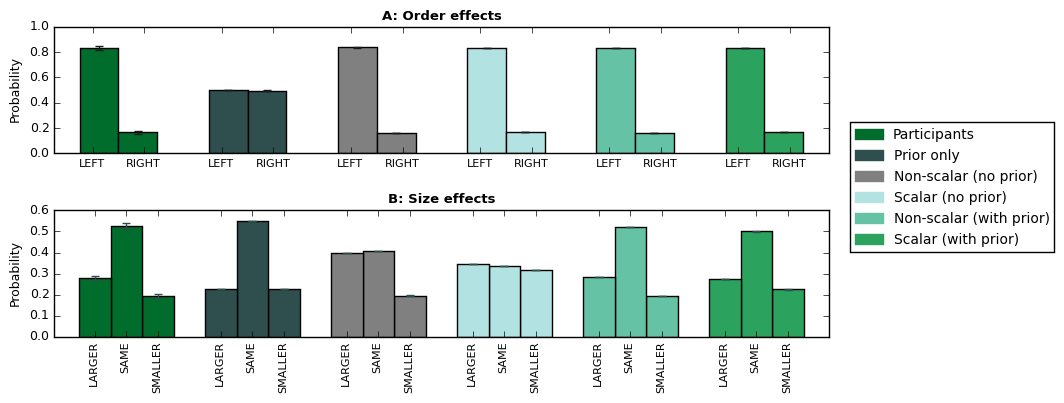

In [61]:
# Plot order and size preferences. 
# Information for the models is produced by the "generate predictions" section of the modeling code. 

fig = plt.figure(figsize=(10,4))

plt.subplot(211)
width = 0.3
pos = [0,1,2,3,4,5]
colors = ['#006d2c', 'darkslategray', 'gray', '#b2e2e2', '#66c2a4', '#2ca25f']
labels = ['Participants', 'Prior only', 'Non-scalar (no prior)', 
          'Scalar (no prior)', 'Non-scalar (with prior)', 'Scalar (with prior)']

patches= [mpatches.Patch(color=c, label=l) for c, l in zip(colors, labels)]

numSubs = len(data['Time'].unique())

proportionOnLeft = [.834, .503, .837, .831, .836, .832]   
std = [.136, .007, .005, .006, .005, .005]
stderr = [s / math.sqrt(numSubs) for s in std]

plt.bar([p - width for p in pos], proportionOnLeft, width=width, color=colors, yerr=stderr, 
        error_kw=dict(ecolor=[.1, .1, .1], lw=1, capsize=3, capthick=1))
plt.bar([p for p in pos], [1 - x for x in proportionOnLeft], width=width, color=colors, yerr=stderr,
        error_kw=dict(ecolor=[.1, .1, .1], lw=1, capsize=3, capthick=1))
plt.xlim([-0.5, 5.5])
plt.ylim([0,1])
plt.legend(handles=patches, fontsize=10, bbox_to_anchor=(1.3, 0.3))

ticks = sorted([p - width*2/3 for p in pos] + [p + width*2/3 for p in pos])
labels = []
for p in pos:
    labels.append('LEFT')
    labels.append('RIGHT')
    

matplotlib.rcParams.update({'font.size': 9})
#plt.xlabel('Location of the image mentioned first')
plt.ylabel('Probability', fontsize=9)
_ = plt.xticks(ticks, labels, fontsize=8)
plt.title('A: Order effects', {'fontweight': 'bold', 'fontsize': 9.5})

##############

plt.subplot(212)

width = 0.25

patches= [mpatches.Patch(color=c, label=l) for c, l in zip(colors, labels)]

proportionSmaller = [.195, .226, .196, .317, .195, .225]
proportionSame = [.526, .548, .407, .337, .521, .500]
std_smaller = [.092, .006, .005, .006, .006, .006]
std_same = [.139, .007, .007, .007, .007, .006]
std_larger = [.112, .007, .007, .007, .006, .006]
stderr_smaller = [s / math.sqrt(numSubs) for s in std_smaller]
stderr_same = [s / math.sqrt(numSubs) for s in std_same]
stderr_larger = [s / math.sqrt(numSubs) for s in std_larger]

plt.bar([p + width for p in pos], proportionSmaller, width=width, color=colors, yerr=stderr_smaller, 
        error_kw=dict(ecolor='darkslategray', lw=1, capsize=3, capthick=1))
plt.bar([p for p in pos], proportionSame, width=width, color=colors, yerr=stderr_same, 
        error_kw=dict(ecolor='darkslategray', lw=1, capsize=3, capthick=1))
plt.bar([p - width for p in pos], [1 - x - y for x,y in zip(proportionSmaller, proportionSame)], 
        width=width, color=colors, yerr=stderr_larger, 
        error_kw=dict(ecolor='darkslategray', lw=1, capsize=3, capthick=1))
plt.ylim([0,0.6])
#plt.legend(handles=patches, fontsize=10, bbox_to_anchor=(1.29, 1))

ticks = sorted([p - width/2 for p in pos] + [p + width/2 for p in pos] + [p + width * 3 / 2 for p in pos])
labels = []
for p in pos:
    labels.append('LARGER')
    labels.append('SAME')
    labels.append('SMALLER')
    
matplotlib.rcParams.update({'font.size': 9})
#plt.xlabel('Size of the image mentioned first')
plt.ylabel('Probability', fontsize=9)
plt.xlim([-0.45, 5.7])
_ = plt.xticks(ticks, labels, fontsize=8, rotation='vertical')
plt.title('B: Size effects', {'fontweight': 'bold', 'fontsize': 9.5})

fig.subplots_adjust(hspace=.45)    

# Convert Data to Long Format for Prior Preference Prediction

In [70]:
# used by mlogit for prior prediction (which is then used by RSA models)

def get_relative_size(value):
    if value['order'] == 1:
        size_left = value['size1']
        size_right = value['size2']
    else:
        size_left = value['size2']
        size_right = value['size1']
    if size_left < size_right:
        return -1 
    elif size_left == size_right:
        return 0
    else:
        return 1

def split_row(row, index):
    df = pd.DataFrame()
    custom_id = index
    for i, option in enumerate(row['Field']):
        new_row = {}
        new_row['custom_id'] = index + 1
        new_row['mode_id'] = int(option['location']) + 1
        rel_size = get_relative_size(option)
        new_row['left_smaller'] = int(rel_size==-1)
        new_row['equal_size'] = int(rel_size==0)
        new_row['left_larger'] = int(rel_size==1)
        new_row['CHOICE'] = int(option==row['Value'])
        new_row['SUB'] = row['Time']
        new_row['ITEM'] = int(row['Group'])
        df = df.append(pd.DataFrame(new_row, index=[i]))
    return df

def convert2long(data):
    data_new = pd.DataFrame()
    for index, row in data.iterrows():
        data_new = data_new.append(split_row(row, index), ignore_index=True)
    return data_new

In [ ]:
test_data = data[(data['Item']!='XX') & (data['Type'] == 'image')]
test_data['Value'] = test_data['Value'].apply(get_vis_condition)
test_data['Field'] = test_data['Field'].apply(get_all_vis_conditions)

prior_data_new = convert2long(prior_data)
test_data_new = convert2long(test_data)

In [77]:
prior_data_new.to_csv('../Data/Processed/prior_data_long.csv', index=False)
test_data_new.to_csv('../Data/Processed/binomial_data_long.csv', index=False)

In [ ]:
### GO TO R, RUN PRIOR PREDICTION ANALYSES

# then convert results into webppl-readable format here
mlogit_prediction = pd.read_csv('../Data/Processed/predictions-mlogit.csv')
del mlogit_prediction['Unnamed: 0']
mlogit_prior = mlogit_prediction.values.tolist()
with open('../Data/Processed/mlogit_prior.txt', 'w') as f:
    json.dump(mlogit_prior, f)